# Object Detection in Google Colab with Fizyr Retinanet

Jupyter notebook providing steps to train a Keras/Tensorflow model for object detection with custom dataset.

It runs in Google Colab using [Fizyr implementation](https://github.com/fizyr/keras-retinanet) of RetinaNet in Keras.

Requirements are only dataset images and annotations file made in [LabelImg](https://github.com/tzutalin/labelImg).

Colab Runtime type: Python3, GPU enabled.

# Environment Setup
Download and install in Colab required packages and import libraries.

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Training10Img

/content/drive/My Drive/Training10Img


In [3]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [4]:
%cd keras-retinanet/

!pip install .

/content/drive/My Drive/Training10Img/keras-retinanet
Processing /content/drive/My Drive/Training10Img/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=168095 sha256=dce6d1eb1676ca6687c58b50342fc210c4058e6ef2adb6589db8b70e9f439472
  Stored in directory: /root/.cache/pip/wheels/f1/3f/9a/c225cc64eb45b66ff5278bb54e9a0a4e5463141b5aeb6770fe
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=c697f8b1fd9518f95a01375c7a288f2df6ee64da4fbf6ea063ce134eefd8ab17
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [5]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [6]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

# Making Dataset

We will be using HyperLabel to create our dataset. You can watch the following tutorial video about how to use HyperLabel and tag images with it.

https://www.youtube.com/embed/R56Ck3tElIs

Once all of your images are tagged, its time to export the labels and data in Pascal VOC format. Goto the `review` tab/section and click on the export button. From the export menu, choose `Object Detection` and select Pascal VOC and click on export. It will take some time to export the data, once exported you should be able to see multiple folders, but we are interested in two i.e., `Annotations` and `JPEGImages` folder.

Now created a new folder, name it `dataset`. Copy all the contents of `Annotations` folder and `JPEGImages` folder inside `dataset` folder and then create a zip archive of this folder.

Upload this zip archive to your Google drive and get the ID. To locate the File ID, right click on the name of the file, choose the Get Shareable Link option, and turn on Link Sharing if needed (you can turn it off later). You will see the link with a combination of numbers and letters at the end, and what you see after id =   is the File ID.

https://drive.google.com/open?id=***ThisIsFileID*** 

If your file is already open in a browser, you can obtain File ID from its link:

https://docs.google.com/spreadsheets/d/***ThisIsFileID***/edit#gid=123456789 

In [7]:
DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [8]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          xmin = ""
          xmax = ""
          ymin = ""
          ymax = ""
          for subsubelem in subelem:
            f = float(subsubelem.text)
            i = int(f)
            if subsubelem.tag == "xmin":
              xmin = str(i)
            if subsubelem.tag == "xmax":
              xmax = str(i)
            if subsubelem.tag == "ymin":
              ymin = str(i)
            if subsubelem.tag == "ymax":
              ymax = str(i)
          
          coords.append(xmin)
          coords.append(ymin)
          coords.append(xmax)
          coords.append(ymax)
            
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

# Training Model

Download pretrained model and run training.

In the next cell choose one option:

1.   download Fizyr Resnet50 pretrained model
2.   download your custom pretrained model, to continue previous training epochs

In the last cell optionally export trained model to Google Drive.


In [9]:
import urllib.request

In [10]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet152_oid_v1.0.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/resnet50_csv_10.h5'
#shutil.copy(DRIVE_MODEL, './snapshots/resnet50_csv_10.h5')


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
!python3 keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 2 --steps 5 --epochs 30 csv annotations.csv classes.csv

2020-12-11 10:17:31.695435: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-12-11 10:17:34.153481: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-11 10:17:34.216630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-11 10:17:34.217230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-11 10:17:34.217273: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-11 10:17:34.424535: I t

In [ ]:
#### OPTIONAL: EXPORT TRAINED MODEL TO DRIVE ####
drive.mount('/content/gdrive')
COLAB_MODEL = './snapshots/resnet50_csv_10.h5'
DRIVE_DIR = '/content/gdrive/My Drive/Colab Notebooks/'
shutil.copy(COLAB_MODEL, DRIVE_DIR)

# Inference
Run inference with uploaded image on trained model.

In [ ]:
THRES_SCORE = 0.8

In [ ]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

In [ ]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

In [ ]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      print(caption)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving DSCN8678.JPG to DSCN8678 (1).JPG
Running inference on: DSCN8678.JPG
processing time:  0.328305721282959
Sailboat 0.876


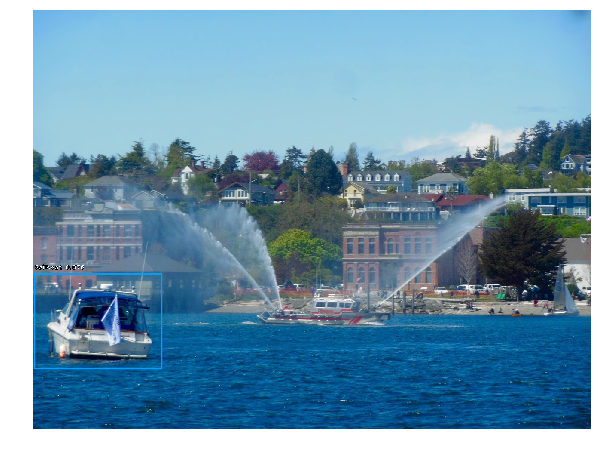

In [ ]:

uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)